# Анализ оттока клиентов для сети фитнес-клубов

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Задача исследования — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 - выделить целевые группы клиентов;
 - предложить меры по снижению оттока;
 - определить другие особенности взаимодействия с клиентами.

In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans


import seaborn as sns
import matplotlib.pyplot as plt
import itertools


In [121]:
import warnings
warnings.filterwarnings('ignore')

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
1. Данные клиента за предыдущий до проверки факта оттока месяц:
 - 'gender' — пол;
 - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
 - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - 'Phone' — наличие контактного телефона;
 - 'Age' — возраст;
 - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
 - 'Group_visits' — факт посещения групповых занятий;
 - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
 - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
 - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
 - 'Churn' — факт оттока в текущем месяце.

In [122]:
try:
  gym = pd.read_csv('/content/drive/MyDrive/Data/gym_churn.csv')
except:
  gym = pd.read_csv('/datasets/gym_churn.csv')

In [123]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных (EDA)

In [124]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Первичный просмотр данных показал:

- все данные заполнены.
- поля gender, near_location, partner, promo_friends, phone, group_visits, churn заполнены бинарными значениями 0 и 1.
- все данные в числовом формате: целое число и дробное.

Вносить изменения в данные нет необходимости.

In [125]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Для полей в бинарной классификации стандартное отклонение достаточно высокое. Это нормальное явление т.к одна группа может значительно превышать другую. Данные Age имеют низкий показатеь стандартного отклонения, т.к. большинство клиентов соотвестсвуют среднему взрасту 29 лет. А например Avg_additional_charge_total имеет большое стандартное отклонение, т.к. разброс значений больше. Среднее 136, 25% - 68, 75% - 210. Думаю очищать данные от выбросов не нужно, т.к. это нормально для подобного значения.

На основе средних значений составим предварительный портрет клиента:
- Доля мужчин и женщин примерно одинаковая.
- Большинство клиентов расположены рядосм с клубом.
- Партнерские и промо программы использовали менее половины клиентов.
- Больше всего клиенты приобретают абонементы на 1 месяц.
- Групповые визиты используются не часто.
- Средний возраст клиента 29 лет. Большинство клиентов в возрасте 27-31 лет.
- В основном клиенты посещают клуб от 1 до 5 месяцев, 1-2 раза в неделю.

No handles with labels found to put in legend.


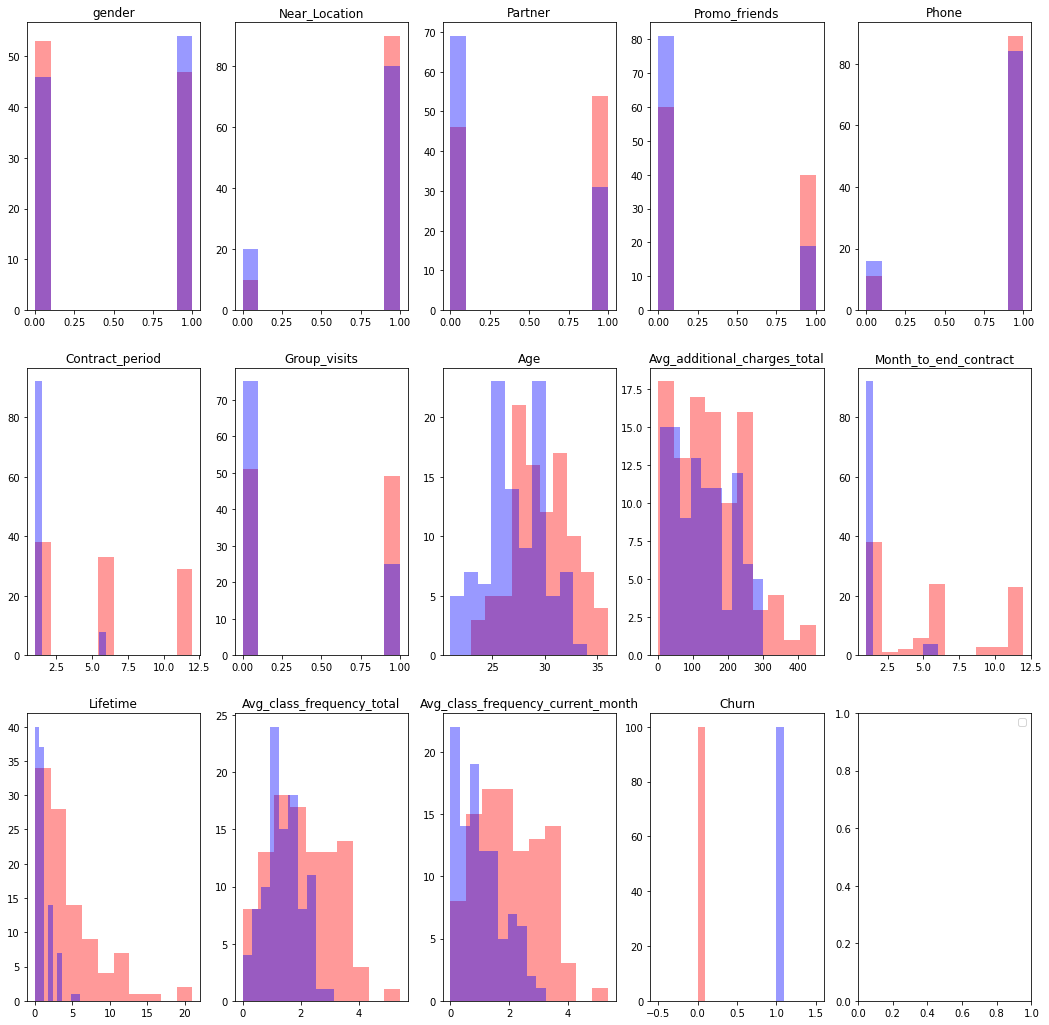

In [126]:
num_cols = gym.columns
fig, ax = plt.subplots(3, 5, figsize=(18,18))
ax = ax.flatten()
for i in range(len(num_cols)):
    ax[i].set_title(num_cols[i])
    ax[i].hist(gym.query('Churn == 0')[num_cols[i]][:100], label='0', color='red', alpha=0.4)
    ax[i].hist(gym.query('Churn == 1')[num_cols[i]][:100], label='1', color='blue', alpha=0.4)
plt.legend()
plt.show()

На основании гистограмм можносделаь следующие выводы:
1. Пол клиента не влияет на отток, гистограммы одинаковые.
2. Близость к фитнес - клубу тоже не влияет, на гистограмме значение 0 значительно ниже чем 1, но это связано  тем, что в датасете единиц больше чем нулей. А среди 1, отток клиентов отличается на 10 единиц. 
3. Партнерская программа и программа Promo_friends влияют на сохранение клиента. Отток выше среди клиентов без партнерской программы или промо.
4. Телефон не влияет на удержание клиента. В базе незначительное число клиентов не указали номер телефона. 
5. Срок котракта влияет на отток. Самый большой отток среди клиентов, купивших абонемент на 1 месяц.
6. Групповые визиты - отток больше среди клиентов, не использующих групповые визиты. Но сделать выводы сложно, т.к. таких клиентов подавляющее большинство.
7. Возраст не влияет на отток клиентов. Самый большой отток среди клиентов 25-30 лет, но  удержание самое большое в этой же категории.
8. Дополнительные покупки в клубе возможно помогают удержать клиентов, удержание выше среди клиентов, оплачивающих дополнительные услуги. но разница не сильно большая, поэтому нельзя говроить о сильном влиянии.
9. Количество месяцев до окончания контракта не влияет на отток. На гистограмме видно большой показатель оттока в диапазоне до 1 месяца, но думаю это клиенты, купившие абонемент на 1 месяц.
10. Период использования абонемента влияет на отток клиентов. Отток происходит у клиентов использовавших абонемент до 5 месяцев. Самые большие значения - 1 месяц и далее показатель уменьшается.
11. Частота посещения влияет на отток. Клиент посещающий клуб 1-2 раза в неделю чаще бросает заниятия. Если смотреть посещения текущего месяца, то самый большой оттк у клиентов не посетивших клуб или посетивших 1 раз. 

<AxesSubplot:>

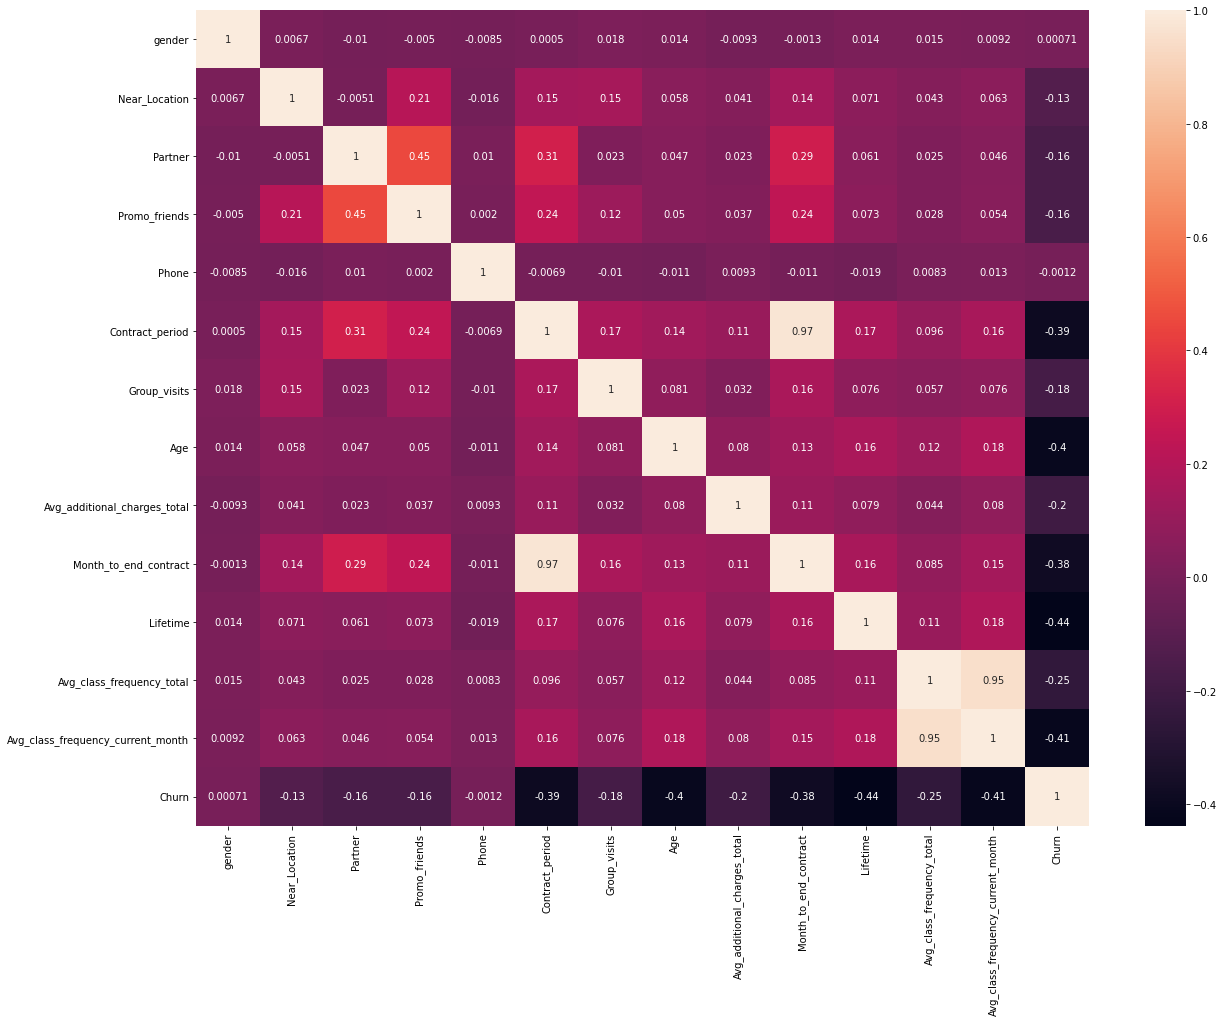

In [127]:
plt.figure(figsize=(20, 15))
sns.heatmap(data=gym.corr(),
           annot = True)

Матрица кореляции показывает высокие значения только в показателях:
- Срок контракта и Количество месяцев до окончания.  
- Частота посещения всего и Частота посещения в текущем месяце.
Корреляция больше 90%.

Для дальнейшего анализа удалим Количество месяцев до окончания контракта и Частота посещения всего

In [128]:
gym = gym.drop(['Month_to_end_contract',
              'Avg_class_frequency_total'], axis=1)


## Модель прогнозирования оттока клиентов

Построем модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [129]:
X = gym.drop(columns=['Churn'], axis=1)
y = gym['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [130]:
models = [LogisticRegression(random_state=0), 
          RandomForestClassifier(random_state=0)]


In [131]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)))


# напишите цикл, который выводит метрики по списку моделей
for i in models:
  print(i)
  make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(random_state=0)
Accuracy:0.88 Precision:0.79 Recall:0.76
RandomForestClassifier(random_state=0)
Accuracy:0.90 Precision:0.82 Recall:0.80


Обе модели показывают хорошие метрики. RandomForestClassifier показывает себя на несколько процентов лучше. Метрика Recall лучше практически на 10 процентов.

## Кластеризация клиентов

Проведем кластеризацию клиентов. Для начала нобходимо стандартизировать данные. Построим дендрограмму  и воспользуемс моделью KMean для кластеризации клиентов.

In [132]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)

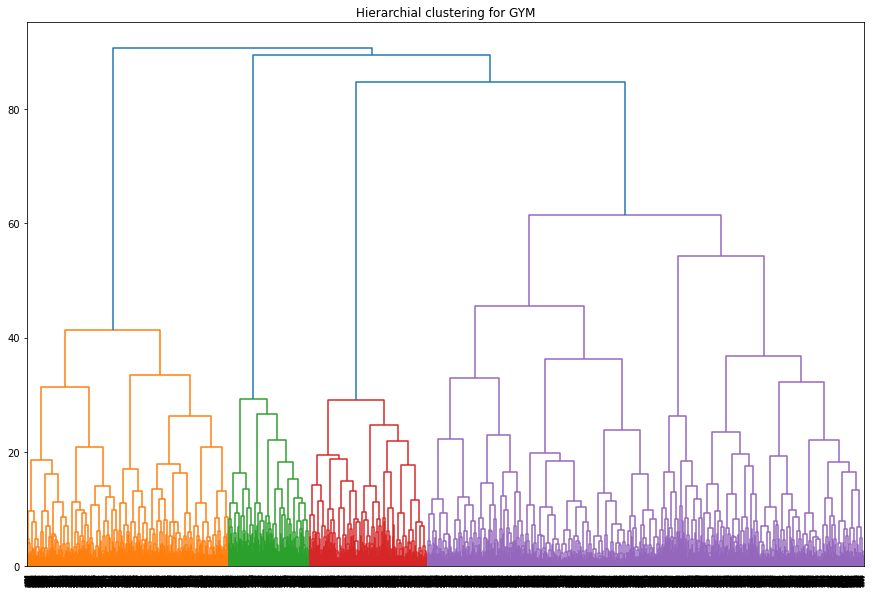

In [133]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

На дендрограмме можно выделить 4 кластера. Но по условиям задания будем делить на 5 кластеров.

In [134]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров 


In [135]:
gym['cluster_km'] = labels
gym.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


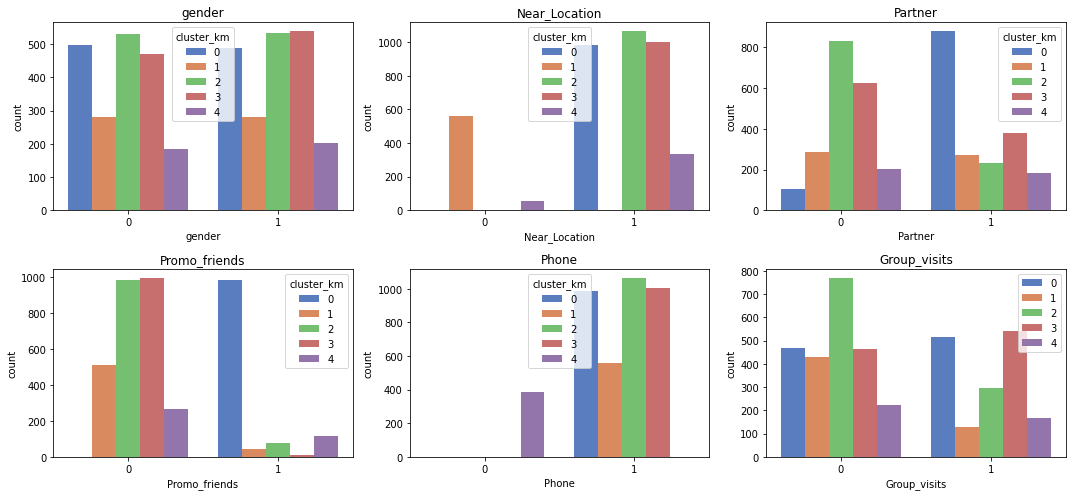

In [147]:
categorical_columns = ['gender',
                      'Near_Location',
                      'Partner',
                      'Promo_friends',
                      'Phone',
                      'Group_visits']  


fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes=axes.ravel()

for column, ax in zip(categorical_columns, axes):
    ax.set_title(column)
    sns.countplot(x=column, hue="cluster_km", data=gym, ax=ax, palette="muted")
    
fig.tight_layout()
plt.legend()
plt.show()

Посмотрим на распределение клиентов по кластерам на основе категориальных признаков:
- Пол - доля мужчин и женщин в каждом кластере примерно одинаковая.
- Близость расположения клуба - в первом кластере собраны клиенты проживающие далеко от клуба, в остальных кластерах 86-97%% близко расположенных.
- Партнерская программа и промо - Во втором кластере собраны клиенты, которые в большинстве случаев не используют промо-акции, партнерскую программу. в 0 кластере большинство клиентов по партнерской программе.
- Номер телефона - клиенты не указавшие номер телефона собраны в 4 кластере
- Групповые визиты - нельзя сказать что по этому признаку разделены клиенты, но можно выделить что во второй группе много клиентов не использующих групповые визиты.

No handles with labels found to put in legend.


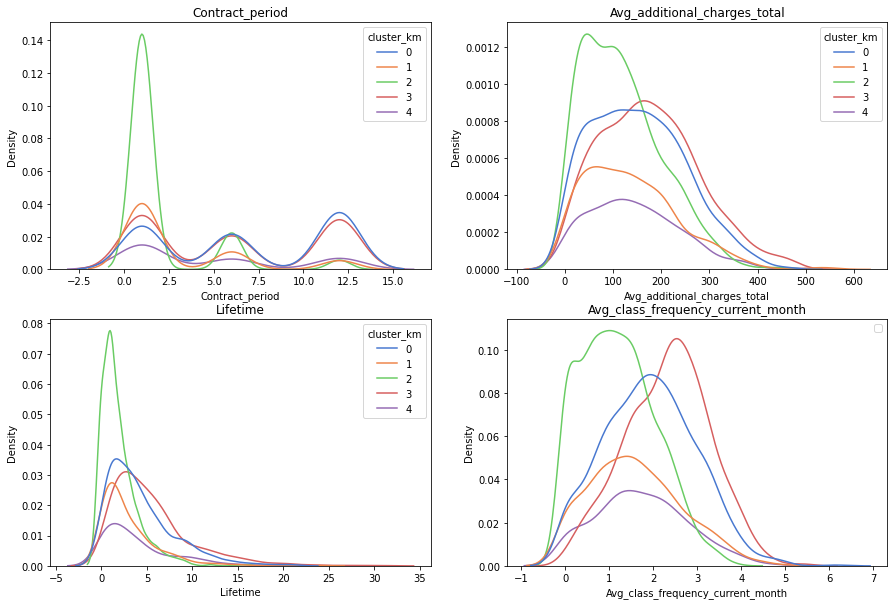

In [146]:
numerical_columns = ['Contract_period',
                    'Avg_additional_charges_total',
                    'Lifetime',
                    'Avg_class_frequency_current_month']  


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes=axes.ravel()

for column, ax in zip(numerical_columns, axes):
    ax.set_title(column)
    sns.kdeplot(data=gym, x=column, hue="cluster_km", ax=ax, 
                palette="muted")
plt.legend()
plt.show()

Посмотрим на распределение клиентов по кластерам на основе количественных признаков:

- Срок контракта - во 2 кластере большинство клиентов с абонеменом на 1 месяц, в остальных кластерах - разные абонементы.
- Возраст - во всех кластерах средний возраст примено одинаковый.
- Оплата дополнительных услуг - средний чек во всех группах отличается незначительно.
- Срок пользования клубом - во втором кластере большинство клиентов посещали клуб в течение 1 месяца. В остальных кластерах от 1 до 5 месяцев
- Частота посещения клуба - самое большое значение в 3 кластере, самое низкое во 2-м.
- Отток - самые высокие значения оттока в 1 и 2 кластере. 

Анализ средних значений показателей в кластерах показал что самый большой отток приходится на 1 и 2 кластеры. В этих группах самые маленькие значения срока контракта и частоты посещения. Также видим что в 1 кластере собраны клиенты, проживающие далеко от клуба, но во 2 кластере все клиенты проживают близко к клубу, но при этом у них тоже высокий отток. Думаю можно сказать что удаленность влияет на отток, но и близость расположения не гарантирует сохранность клиента. 

Также можно обратить внимание что большинство клиентов 2 кластера не используют групповые визиты, партнерскую программу и промо акцию. 

По остальным показателям клиенты разделены примено одинаково.  

In [141]:
gym.groupby('cluster_km')['Churn'].mean()*100


cluster_km
0    11.979695
1    40.322581
2    56.390977
3     1.489573
4    26.683938
Name: Churn, dtype: float64

Средние значения оттока клиентов также показывают самые большие проценты во 2 и 3 кластере.

## Вывод

Проведен анализ оттока клиентов сети фитнес-клубов. Анализ показал что на отток клиентов влияют:
- частота посещения клуба,
- срок абонемента
- удаленность клиента

На основе модели KMEAN проведена кластеризация клиентов. Клиенты разделены на 5 групп. Анализ средних значений показателей в кластерах показал что самый большой отток приходится на 1 и 2 кластеры. В этих группах самые маленькие значения срока контракта и частоты посещения. Также видим что в 1 кластере собраны клиенты, проживающие далеко от клуба, но во 2 кластере все клиенты проживают близко к клубу, но при этом у них тоже высокий отток. Думаю можно сказать что удаленность влияет на отток, но и близость расположения не гарантирует сохранность клиента. 

Также можно обратить внимание что большинство клиентов 2 кластера не используют групповые визиты, партнерскую программу и промо акцию. 

По остальным показателям клиенты разделены примено одинаково. 

Для повышения удержания клиентов стоит пересмотреть сроки абонементов или мотивировать покупать на больший срок. Также стоит мотивировать клиентов на более частое посещение клуба.
Среди клиентов 3 кластера сделать рассылку мотивационных программ клуба.